# ESM1 Plotting
The purpose of this notebook is to access the CMIP6 data sets and present the ESM1 temperature data from historic simulations

#### Imports

In [1]:
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

#### Accessing Dataset Database

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

#### Filtering for relevant data sets
ESM3 data sets

In [3]:
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270787,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271418,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401215,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401216,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430471,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


Ocean area data to be used for averaging

In [4]:
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

73 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
57940,CMIP,NCAR,CESM2,historical,r2i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
58003,CMIP,NCAR,CESM2,historical,r2i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
58870,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
58871,CMIP,NCAR,CESM2,historical,r1i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
59165,CMIP,NCAR,CESM2,historical,r4i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308


#### Opening all datafiles
ESM3 data

In [5]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

Ocean Area data

In [6]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[0]), consolidated=True)
dataArea = dsArea.areacello

#### Combine data sets into one xarray

In [7]:
for i in range(fileCount):
    fileSetList[i]['time']=('time',np.arange('1850-01-16','2015-01-16',dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds',np.arange('1850-01-16','2015-01-16',dtype='datetime64[M]'))
fileSet = xr.combine_nested(fileSetList, concat_dim='SetNo')
fileSet

<xarray.Dataset>
Dimensions:    (SetNo: 5, bnds: 2, bound: 2, lat: 180, lev: 60, lon: 360, time: 1980, time_bnds: 1980)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (SetNo, lat, bnds, bound) float64 dask.array<chunksize=(1, 180, 2, 2), meta=np.ndarray>
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
    lev_bnds   (SetNo, lev, bnds, bound) float64 dask.array<chunksize=(1, 60, 2, 2), meta=np.ndarray>
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (SetNo, lon, bnds, bound) float64 dask.array<chunksize=(1, 360, 2, 2), meta=np.ndarray>
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
  * time_bnds  (time_bnds) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
Dimensions without coordinates: SetNo, bnds, bound
Data variables:
    thetao     (SetNo, time, lev, lat, lon) float32 dask.array<chunksize=(1, 6, 60, 180, 360), meta=np.ndarray>

#### Selection of Data

In [8]:
dataFiltLatLev = fileSet.thetao.sel(lat=slice(-89.5,-29.5), lev=5.0)
dataFiltFull = dataFiltLatLev.sel(time='1950-01')
dataFiltFull

<xarray.DataArray 'thetao' (SetNo: 5, time: 1, lat: 61, lon: 360)>
dask.array<getitem, shape=(5, 1, 61, 360), dtype=float32, chunksize=(1, 1, 61, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5 -29.5
    lev      float64 5.0
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1950-01-01
Dimensions without coordinates: SetNo

#### Calculation
Average temperature of fully filtered data

In [9]:
totalArea = dataArea.sum(dim=['lon', 'lat'])
sample = dataFiltFull.sel(SetNo=0)
taTimeSeries = (sample*dataArea).sum(dim=['lon', 'lat']) / totalArea  

In [10]:
taTimeSeries.load()

<xarray.DataArray (time: 1)>
array([2.60394595])
Coordinates:
    lev      float64 5.0
  * time     (time) datetime64[ns] 1950-01-01

#### Presentation of data

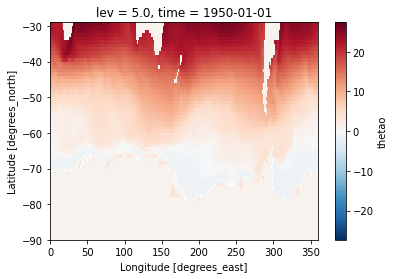

In [11]:
sample.squeeze().plot()